# Plot All Results (Fixed Agents)

Plot results for unreliable agents that have fixed behavior.

In [1]:
import csv
import os
import pathlib
import json
import pickle
from pprint import pprint
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(
    context="paper",
    style="whitegrid",
#     font_scale=2,
    rc={
        'lines.linewidth': 2,
#         'xtick.bottom': True,
#         'ytick.left': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
    }
)

In [2]:
# Use latex for exporting
# mpl.use("pgf")  # can specify this as an argument to savefig() each time
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Results format

Results are stored as subfolders, each with a timestamp (e.g. `res_20220306_155424`),
in a root folder `results`.
`results` also contains a CSV called `timestamps.csv` listing the timestamps of each results folder along with configuration parameters.

Each result subfolder contains `config.json`, which gives the experimental configuration used to run experiments (must match the entry in `timestamps.csv`), and `results.json` which contains the collected data.

Each `results.json` contains a list of $N$ 2-tuples, where $N$ is the number of separate runs (each with a different random seed).
Each tuple contains the training and evaluation data respectively, each being a dictionary.
Each of these dicts are in the following key-value format: `metric : list of values over episodes` 

## Load Data

In [3]:
# Location of root folder containing all result subfolders
NUM_AGENTS = 16
RESULTS_PATH = pathlib.Path(f"../results-{NUM_AGENTS}-agents/")

# Names of metrics in each result folder
METRIC_NAMES = [
    'average_reward',
    'success_rate',
    'average_trust_rate',
    'mutual_trust_rate',
    'average_trust_accuracy'
]

# Convert metric names (lower case, joined by underscores) to human-readable (capitalised with spaces)
METRIC_TO_LABEL = {
    'average_reward': 'Reward',
    'average_trust_accuracy': 'Trust Accuracy',
    'average_trust_rate': 'Trust Rate',
    'mutual_trust_rate': 'Mutual Trust',
    'success_rate': 'Success Rate'
}

# Similarly, variable to human readable
VAR_TO_LABEL = {
    "noise": "$1 - p$",  # "Noise"
    "frac_reliable": "$f$" # "Reliable Fraction"
}

RUNMODE_TO_LABEL = {
    "trained": "RLTC",
    "oracle": "Oracle",
    "trust_all" : "Trust All"
}

RUNMODES = list(RUNMODE_TO_LABEL.keys())

In [4]:
# Collect data from 
all_data = []

for path in RESULTS_PATH.iterdir():
    if not path.name.startswith("res_"):
        continue
    
    timestamp = path.name
    files = {file.name for file in path.iterdir()}
    assert files == {"config.json", "results.json"}
    
    with open(path.joinpath("config.json"), "r") as f:
        config = json.load(f)
    
    with open(path.joinpath("results.json"), "r") as f:
        results = json.load(f)
    
    row = config.copy()
    row["timestamp"] = timestamp
    row["results"] = results
    
    all_data.append(row)

In [5]:
# Basic sanity check
assert len(set(row["timestamp"] for row in all_data)) == len(all_data)
assert all(all_data[0].keys() == row.keys() for row in all_data)

COLUMN_NAMES = list(sorted(all_data[0].keys()))

df_main = pd.DataFrame(all_data)
df_main.head(3)

,num_processes,frac_reliable,noise,episode_length,run_mode,step_size,discount,epsilon,epsilon_decay_factor,num_train_episodes,num_eval_episodes,timestamp,results
0,16,1.00,0.1,30,oracle,0.03,0.999,0.3,0.9996,20000,2000,res_20220321_071615431095_40,"[[{'average_reward': [], 'success_rate': [], '..."
1,16,0.25,0.0,30,trust_all,0.03,0.999,0.3,0.9996,20000,2000,res_20220320_173159361355_2,"[[{'average_reward': [], 'success_rate': [], '..."
2,16,1.00,0.3,30,trust_all,0.03,0.999,0.3,0.9996,20000,2000,res_20220321_092317582480_47,"[[{'average_reward': [], 'success_rate': [], '..."


In [6]:
df_main[(df_main["frac_reliable"] == 0.75) & (df_main["noise"] == 0.3)]

,num_processes,frac_reliable,noise,episode_length,run_mode,step_size,discount,epsilon,epsilon_decay_factor,num_train_episodes,num_eval_episodes,timestamp,results
8,16,0.75,0.3,30,trust_all,0.03,0.999,0.3,0.9996,20000,2000,res_20220321_051400199746_35,"[[{'average_reward': [], 'success_rate': [], '..."
15,16,0.75,0.3,30,trained,0.03,0.999,0.3,0.9996,20000,2000,res_20220321_050900374389_33,"[[{'average_reward': [-29.333333333333332, -25..."
42,16,0.75,0.3,30,oracle,0.03,0.999,0.3,0.9996,20000,2000,res_20220321_051132235408_34,"[[{'average_reward': [], 'success_rate': [], '..."


In [7]:
def extract(row, metric):
    """Extract evaluation results for a particular metric."""
        
    results = row["results"]
    
    # all_train_results = []
    all_eval_results = []
    
    for train_result, eval_result in results:
        # all_train_results.append(train_result)
        all_eval_results.append(eval_result)
    
    return [item[metric] for item in all_eval_results]

# For each metric, get the raw data using extract(), then replace with averages
for metric in METRIC_NAMES:
    df_main[metric] = df_main.apply(lambda x: extract(x, metric), axis=1)
    df_main[metric] = df_main[metric].apply(lambda xs: [np.mean(x) for x in xs])

In [8]:
# Show results
# (excluding the original "results" column makes displaying faster)
df_main[df_main.columns.difference(["results"])]

,average_reward,average_trust_accuracy,average_trust_rate,discount,episode_length,epsilon,epsilon_decay_factor,frac_reliable,mutual_trust_rate,noise,num_eval_episodes,num_processes,num_train_episodes,run_mode,step_size,success_rate,timestamp
0,"[19.311125, 19.6568125, 18.788375, 18.760875, ...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,1.00,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.1,2000,16,20000,oracle,0.03,"[27.05771875, 27.1198125, 26.8723125, 26.8975,...",res_20220321_071615431095_40
1,"[-30.0, -30.0, -30.0, -30.0, -29.71175, -30.0,...","[6.249999999999999, 5.0, 6.249999999999999, 4....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,0.25,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 0.0, 30.0...",0.0,2000,16,20000,trust_all,0.03,"[0.9095, 0.690625, 0.8315, 0.66775, 1.869125, ...",res_20220320_173159361355_2
2,"[2.1841875, 1.3919375, 0.977125, 0.5166875, 2....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,1.00,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,16,20000,trust_all,0.03,"[21.26259375, 20.95621875, 20.81421875, 20.653...",res_20220321_092317582480_47
3,"[-30.0, -30.0, -30.0, -30.0, -29.485875, -29.9...","[16.562500000000004, 15.0, 11.875000000000002,...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,0.50,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,16,20000,trust_all,0.03,"[1.6886875, 1.365, 0.950375, 0.8186875, 2.5315...",res_20220320_202958766055_23
4,"[-20.346083333333336, -22.571416666666668, -27...","[7.305555555555555, 12.840277777777777, 13.687...","[4.347222222222222, 6.715277777777778, 7.17361...",0.999,30,0.3,0.9996,0.75,"[1.3125, 0.6923076923076923, 0.5, 2.0666666666...",0.1,2000,16,20000,trained,0.03,"[19.137208333333337, 19.399791666666665, 9.983...",res_20220320_215855576342_27
5,"[-30.0, -30.0, -30.0, -30.0, -19.7565, -30.0, ...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[6.249999999999999, 5.0, 6.249999999999999, 4....",0.999,30,0.3,0.9996,0.25,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 0.0, 30.0...",0.3,2000,16,20000,oracle,0.03,"[20.85675, 21.16125, 20.789875, 21.100125, 21....",res_20220320_182101805106_10
6,"[-9.107416666666666, -19.915583333333334, -15....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[25.416666666666647, 21.458333333333353, 20.83...",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.2,2000,16,20000,oracle,0.03,"[24.144166666666663, 23.647333333333336, 23.96...",res_20220320_224830207301_31
7,"[-30.0, -30.0, -30.0, -30.0, -29.84075, -30.0,...","[6.249999999999999, 5.0, 6.249999999999999, 4....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,0.25,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 0.0, 30.0...",0.3,2000,16,20000,trust_all,0.03,"[0.644125, 0.486625, 0.58925, 0.4725, 1.309625...",res_20220320_182156445804_11
8,"[-28.10441666666667, -29.439333333333334, -29....","[25.416666666666647, 21.458333333333353, 20.83...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,16,20000,trust_all,0.03,"[6.11825, 3.275208333333333, 3.093333333333333...",res_20220321_051400199746_35
9,"[-4.744666666666666, -17.51125, -12.95625, -4....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[25.416666666666647, 21.458333333333353, 20.83...",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.1,2000,16,20000,oracle,0.03,"[27.101, 26.952875, 26.97866666666667, 27.0421...",res_20220320_220124999206_28


In [9]:
# Delete unused results column
del df_main["results"]

## Plot Data

In [10]:
# Don't include rewards for now (so we get a 4-column grid)
metric_names = [name for name in METRIC_NAMES if name != "average_reward"]
assert len(metric_names) == 4

# Get the episode length (should be the same across all results)
episode_lengths = pd.unique(df_main["episode_length"])
assert len(episode_lengths) == 1
EPISODE_LENGTH = episode_lengths[0]
print(EPISODE_LENGTH)

30


In [11]:
def plot_metrics(df, metric_names, x_var="noise", control_var="frac_reliable", groupby_var="run_mode"):
    """Plot metrics in a grid.
    
    df: pandas dataframe to use
    metric_names: list of metrics labels to plot
    x_var: variable to hold constant (goes on the x axis per plot)
    control_var: control variable (fixed value per column)
    groupby_var: plot separate lines for each group, default run_mode (trained, oracle, trust_all)
    
    y_var is the metric by default, one metric per row.
    
    In the experiments, we varied both noise and frac_reliable.
    For this plot, we vary one (x_var) while keeping the other fixed (control_var).
    """

    # In the experiments, we varied both noise and frac_reliable,
    # so we vary one (X) and fix the other (control).
    control_unique_values = list(df[control_var].unique())
    control_unique_values.sort()
    
    # Manually set the x axis ticks and limits using this
    x_unique_values = list(df[x_var].unique())
    x_value_range = min(x_unique_values), max(x_unique_values)
    
    # For setting y-limits of plot
    # (all metric values `should` be between 0 and 1)
    metric_range = 0.0, 1.0
    
    # For seaborn hue_order/style_order
    groupby_values = list(df[groupby_var].unique())
    groupby_values.sort()

    fig, axs = plt.subplots(
        len(metric_names),
        len(control_unique_values),
        figsize=(16, 16),
#         tight_layout=True,
        sharex=True,
        sharey=True,
    )
    fig.subplots_adjust(left=0.0, right=1.0, wspace=0.3, hspace=0.28)

    for i, (axs_row, metric) in enumerate(zip(axs, metric_names)):

        # Expand results list to rows
        df_metric = df[[x_var, groupby_var, control_var, metric]]
        df_metric = df_metric.explode(metric).reset_index(drop=True)

        # Results are summed over timesteps.
        # Divide through to get per-timestep averages
        df_metric[metric] = df_metric[metric].astype("float64") / EPISODE_LENGTH
        
        for j, (ax, control_value) in enumerate(zip(axs_row, control_unique_values)):

            # Extract subset of data that we need from the full set
            df_plot = df_metric[df_metric[control_var] == control_value]        

            # Line plot with error band (1 stddev)
            sns.lineplot(
                ax=ax,
                data=df_plot,
                x=x_var,
                y=metric,
                hue=groupby_var,
                hue_order=groupby_values,
                ci="sd",
                style=groupby_var,
                style_order=groupby_values,
                markers=True,

                # Draw line and dots over the overlapping axis lines
                clip_on=False,
                zorder=100,
            )

            # Metric is shared across the row, so we just show y label for the first column.
            # Also convert y label to its human-readable name
            if j == 0:
                ax.set_ylabel(METRIC_TO_LABEL[metric])

            # Make the column title frac_reliable (human readable)
            if i == 0:
                ax.set_title(control_value)

            # Remove X label, because it is shared across subplots.
            # A supxlabel will be used instead
            ax.set_xlabel(None)
            
            # Remove y labels except first column
            if j > 0:
                ax.set_ylabel(None)

            # Remove legend (show a global one once)
            ax.legend([],[], frameon=False)

            # Avoid plotting beyond value ranges
            ax.set_xlim(x_value_range)
            ax.set_ylim(metric_range)

            # Set axis tickers
            ax.set_xticks(x_unique_values)
            ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            
            # Major and minor gridlines
            ax.grid(visible=True, which='major', linewidth=1.0)
            ax.grid(visible=True, which='minor', linewidth=0.5)
            
            # Padding between tick labels and plot
            ax.xaxis.set_tick_params(pad=0.1)
            ax.yaxis.set_tick_params(pad=0.1)
            
    # Global legend
    handles, labels = ax.get_legend_handles_labels()

    # Manually convert legend to human-readable name
    for i in range(len(labels)):
        labels[i] = RUNMODE_TO_LABEL[labels[i]]
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.04))

    # Reduce the space between plots and this label
    center_x = (fig.subplotpars.left + fig.subplotpars.right) / 2
    fig.supxlabel(VAR_TO_LABEL[x_var], y=0.035, horizontalalignment='center', x=center_x);
    fig.suptitle(VAR_TO_LABEL[control_var], y=0.95, horizontalalignment='center', x=center_x)
    
    return fig, axs

### Reliable fraction vs metric (noise const.)

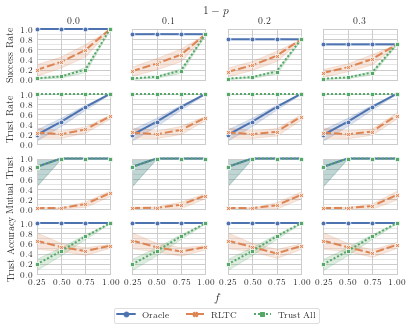

In [12]:
fig, axs = plot_metrics(df_main, metric_names, x_var="frac_reliable", control_var="noise", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=5, h=4.5)

# fig.set_tight_layout(True)
fig.savefig(f"frac_reliable_{NUM_AGENTS}_agents.pgf", format="pgf", backend="pgf", bbox_inches='tight')

### Noise vs vs metric (reliable fraction const.)

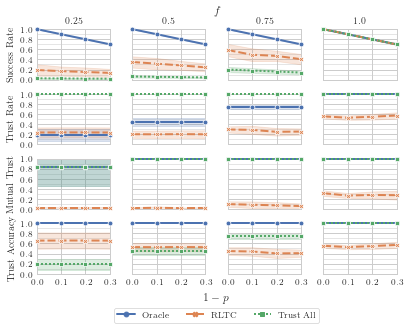

In [13]:
fig, axs = plot_metrics(df_main, metric_names, x_var="noise", control_var="frac_reliable", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=5, h=4.5)
# fig.set_tight_layout(True)
fig.savefig(f"noise_{NUM_AGENTS}_agents.pgf", format="pgf", backend="pgf", bbox_inches='tight')

### Other

In [14]:
# Expand results list to rows
x_var = "frac_reliable"
groupby_var = "run_mode"
control_var = "noise"
metric = "success_rate"

df = df_main
df_metric = df[[x_var, groupby_var, control_var, metric]]
df_metric = df_metric.explode(metric).reset_index(drop=True)

# Results are summed over timesteps.
# Divide through to get per-timestep averages
df_metric[metric] = df_metric[metric].astype("float64") / EPISODE_LENGTH

In [15]:
# Rough estimate of average improvement where there are unreliable agents present.
results = df_metric[df_metric["frac_reliable"] < 1].groupby(groupby_var).agg({
    metric: {'mean'}
})
results

,success_rate
,mean
run_mode,
oracle,0.849803
trained,0.316186
trust_all,0.082539


In [16]:
# Percentage point difference
results.loc["trained", ("success_rate", "mean")] - results.loc["trust_all", ("success_rate", "mean")]

0.2336467997685185

### All metrics except success rate, fraction reliable

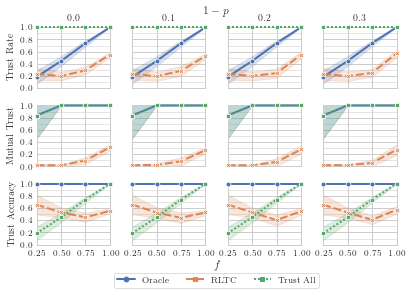

In [17]:
ms = metric_names.copy()
ms.remove("success_rate")

fig, axs = plot_metrics(df_main, ms, x_var="frac_reliable", control_var="noise", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=5, h=4)

# fig.set_tight_layout(True)
fig.savefig(f"trust_frac_reliable_{NUM_AGENTS}_agents.pgf", format="pgf", backend="pgf", bbox_inches='tight')

### Success rate only as bar graphs

In [27]:
def plot_metrics_bar(df, metric_names, x_var="noise", control_var="frac_reliable", groupby_var="run_mode"):
    """Plot metrics in a grid.
    
    df: pandas dataframe to use
    metric_names: list of metrics labels to plot
    x_var: variable to hold constant (goes on the x axis per plot)
    control_var: control variable (fixed value per column)
    groupby_var: plot separate lines for each group, default run_mode (trained, oracle, trust_all)
    
    y_var is the metric by default, one metric per row.
    
    In the experiments, we varied both noise and frac_reliable.
    For this plot, we vary one (x_var) while keeping the other fixed (control_var).
    """

    # In the experiments, we varied both noise and frac_reliable,
    # so we vary one (X) and fix the other (control).
    control_unique_values = list(df[control_var].unique())
    control_unique_values.sort()
    
    # Manually set the x axis ticks and limits using this
    x_unique_values = list(df[x_var].unique())
    x_value_range = min(x_unique_values), max(x_unique_values)
    
    # For setting y-limits of plot
    # (all metric values `should` be between 0 and 1)
    metric_range = 0.0, 1.0
    
    # For seaborn hue_order/style_order
    groupby_values = list(df[groupby_var].unique())
    groupby_values.sort()

    fig, axs = plt.subplots(
        len(metric_names),
        len(control_unique_values),
        figsize=(len(control_unique_values) * 4, len(metric_names) * 4),
        tight_layout=True,
        sharex=True,
        sharey=True,
    )
    if len(metric_names) == 1:
        axs = [axs]

    for i, (axs_row, metric) in enumerate(zip(axs, metric_names)):

        # Expand results list to rows
        df_metric = df[[x_var, groupby_var, control_var, metric]]
        df_metric = df_metric.explode(metric).reset_index(drop=True)

        # Results are summed over timesteps.
        # Divide through to get per-timestep averages
        df_metric[metric] = df_metric[metric].astype("float64") / EPISODE_LENGTH
        
        for j, (ax, control_value) in enumerate(zip(axs_row, control_unique_values)):

            # Extract subset of data that we need from the full set
            df_plot = df_metric[df_metric[control_var] == control_value]        

            # Line plot with error band (1 stddev)
            sns.barplot(
                ax=ax,
                data=df_plot,
                x=x_var,
                y=metric,
                hue=groupby_var,
                hue_order=groupby_values,
                ci="sd",
                capsize=.2,
                errwidth=1
#                 style=groupby_var,
#                 style_order=groupby_values,
#                 markers=True,

#                 # Draw line and dots over the overlapping axis lines
#                 clip_on=False,
#                 zorder=100,
            )

            # Metric is shared across the row, so we just show y label for the first column.
            # Also convert y label to its human-readable name
            if j == 0:
                ax.set_ylabel(METRIC_TO_LABEL[metric])

            # Make the column title frac_reliable (human readable)
            if i == 0:
                ax.set_title("{}".format(control_value))

            # Remove X label, because it is shared across subplots.
            # A supxlabel will be used instead
            ax.set_xlabel(None)
            
            # Remove y labels except first column
            if j > 0:
                ax.set_ylabel(None)

            # Remove legend (show a global one once)
            ax.legend([],[], frameon=False)

#             # Avoid plotting beyond value ranges
#             ax.set_xlim(x_value_range)
#             ax.set_ylim(metric_range)

            # Set axis tickers
#             ax.set_xticks(x_unique_values)
            ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            
            # Major and minor gridlines
            ax.grid(visible=True, which='major', linewidth=1.0)
            ax.grid(visible=True, which='minor', linewidth=0.5)
            
    # Global legend
    handles, labels = ax.get_legend_handles_labels()

    # Manually convert legend to human-readable name
    for i in range(len(labels)):
        labels[i] = RUNMODE_TO_LABEL[labels[i]]
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

    # Reduce the space between plots and this label
    fig.supxlabel(VAR_TO_LABEL[x_var], y=0.11);
    fig.suptitle(VAR_TO_LABEL[control_var], y=0.85)
    
    return fig, axs

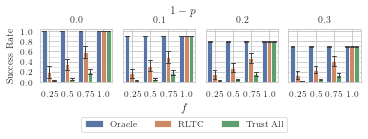

In [28]:
fig, axs = plot_metrics_bar(df_main, ["success_rate"], x_var="frac_reliable", control_var="noise", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=5.2, h=2.0)
# fig.set_tight_layout(True)
fig.savefig(f"success_rate_frac_reliable_{NUM_AGENTS}_agents.pgf", format="pgf", backend="pgf", bbox_inches='tight')